# Cluster GCN for node classification

Import NetworkX and stellar:

In [ ]:
import networkx as nx
import pandas as pd
import itertools
import json
import os

import metis
import numpy as np

from networkx.readwrite import json_graph

from sklearn.preprocessing import StandardScaler

import stellargraph as sg
from stellargraph.mapper import ClusterNodeGenerator
from stellargraph.layer import ClusterGCN
from stellargraph import globalvar

from tensorflow.keras import backend as K

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

import warnings
from scipy.sparse import SparseEfficiencyWarning
warnings.simplefilter('ignore',SparseEfficiencyWarning)

In [2]:
def load_cora(data_dir, largest_cc=False):
    g_nx = nx.read_edgelist(path=os.path.expanduser(os.path.join(data_dir, "cora.cites")))
    
    for edge in g_nx.edges(data=True):
        edge[2]['label'] = 'cites'

    # load the node attribute data
    cora_data_location = os.path.expanduser(os.path.join(data_dir, "cora.content"))
    node_attr = pd.read_csv(cora_data_location, sep='\t', header=None)
    values = { str(row.tolist()[0]): row.tolist()[-1] for _, row in node_attr.iterrows()}
    nx.set_node_attributes(g_nx, values, 'subject')

    if largest_cc:
        # Select the largest connected component. For clarity we ignore isolated
        # nodes and subgraphs; having these in the data does not prevent the
        # algorithm from running and producing valid results.
        g_nx_ccs = (g_nx.subgraph(c).copy() for c in nx.connected_components(g_nx))
        g_nx = max(g_nx_ccs, key=len)
        print("Largest subgraph statistics: {} nodes, {} edges".format(
            g_nx.number_of_nodes(), g_nx.number_of_edges()))
    
    feature_names = ["w_{}".format(ii) for ii in range(1433)]
    column_names =  feature_names + ["subject"]
    node_data = pd.read_csv(os.path.join(data_dir, "cora.content"), 
                              sep="\t", header=None, 
                              names=column_names)
    
    node_data.index = node_data.index.map(str)
    node_data = node_data[node_data.index.isin(list(g_nx.nodes()))]
    
    for nid in node_data.index:
        g_nx.node[nid][globalvar.TYPE_ATTR_NAME] = "paper"  # specify node type

    return g_nx, node_data, feature_names

In [3]:
def load_pubmed(data_dir):
    edgelist = pd.read_csv(os.path.join(data_dir, 'Pubmed-Diabetes.DIRECTED.cites.tab'), 
                             sep="\t", skiprows=2, 
                             header=None )
    edgelist.drop(columns=[0,2], inplace=True)
    edgelist.columns = ['source', 'target']
    # delete unneccessary prefix 
    edgelist['source'] = edgelist['source'].map(lambda x: x.lstrip('paper:')) 
    edgelist['target'] = edgelist['target'].map(lambda x: x.lstrip('paper:'))
    edgelist["label"] = "cites"  # set the edge type
    
    # Load the graph from the edgelist
    g_nx = nx.from_pandas_edgelist(edgelist, edge_attr="label")

    # Load the features and subject for each node in the graph
    nodes_as_dict = []
    with open(os.path.join(os.path.expanduser(data_dir), 
                           "Pubmed-Diabetes.NODE.paper.tab")) as fp:
        for line in itertools.islice(fp, 2, None):
            line_res = line.split("\t")
            pid = line_res[0]
            feat_name = ['pid'] + [l.split("=")[0] for l in line_res[1:]][:-1] # delete summary
            feat_value = [l.split("=")[1] for l in line_res[1:]][:-1] # delete summary
            feat_value = [pid] + [ float(x) for x in feat_value ] # change to numeric from str
            row = dict(zip(feat_name, feat_value))
            nodes_as_dict.append(row)

    # Create a Pandas dataframe holding the node data        
    node_data = pd.DataFrame(nodes_as_dict)
    node_data.fillna(0, inplace=True)
    node_data['label'] = node_data['label'].astype(int)
    node_data['label'] = node_data['label'].astype(str)
    
    node_data.index = node_data['pid']
    node_data.drop(columns=['pid'], inplace=True)
    node_data.head()
    
    for nid in node_data.index:
        g_nx.node[nid][globalvar.TYPE_ATTR_NAME] = "paper"  # specify node type
    
    feature_names = list(node_data.columns)
    feature_names.remove("label")
    
    return g_nx, node_data, feature_names

### Loading the dataset

**Downloading the CORA dataset:**
    
The dataset used in this demo can be downloaded from [here](https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz).

The following is the description of the dataset:
> The Cora dataset consists of 2708 scientific publications classified into one of seven classes.
> The citation network consists of 5429 links. Each publication in the dataset is described by a
> 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary.
> The dictionary consists of 1433 unique words. The README file in the dataset provides more details.

Download and unzip the cora.tgz file to a location on your computer and set the `data_dir` variable to
point to the location of the dataset (the directory containing "cora.cites" and "cora.content").

In [4]:
# Select the dataset; if False, then Pubmed-Diabetes dataset is used.
dataset = 'cora'  # can also select 'pubmed' or 'reddit'
if dataset == 'cora':
    data_dir = os.path.expanduser("~/data/cora")
elif dataset == 'pubmed':
    data_dir = os.path.expanduser("~/data/pubmed/Pubmed-Diabetes/data")

In [5]:
if dataset == 'cora':
    Gnx, node_data, feature_names = load_cora(data_dir)
elif dataset == 'pubmed':
    Gnx, node_data, feature_names = load_pubmed(data_dir)

In [6]:
Gnx.number_of_nodes(), Gnx.number_of_edges()

(2708, 5278)

In [7]:
if dataset == 'cora':
    node_label = "subject"
elif dataset == 'pubmed':
    node_label = "label"

In [8]:
set(node_data[node_label])

{'Case_Based',
 'Genetic_Algorithms',
 'Neural_Networks',
 'Probabilistic_Methods',
 'Reinforcement_Learning',
 'Rule_Learning',
 'Theory'}

### Splitting the data

We aim to train a graph-ML model that will predict the "subject"/"label"/"forum" (depending on the dataset) attribute on the nodes.

For machine learning we want to take a subset of the nodes for training, and use the rest for validation and testing. We'll use scikit-learn again to do this.

Here we're taking 140 node labels for training, 500 for validation, and the rest for testing.

In [9]:
if dataset == 'cora':
    train_size = 140
elif dataset == 'pubmed':
    train_size = 60
    
train_data, test_data = model_selection.train_test_split(
    node_data, 
    train_size=train_size, 
    test_size=None, 
    stratify=node_data[node_label]
)
val_data, test_data = model_selection.train_test_split(
    test_data, 
    train_size=500, 
    test_size=None, 
    stratify=test_data[node_label]
)

Note using stratified sampling gives the following counts:

In [10]:
from collections import Counter
Counter(train_data[node_label])

Counter({'Probabilistic_Methods': 22,
         'Reinforcement_Learning': 11,
         'Genetic_Algorithms': 22,
         'Theory': 18,
         'Case_Based': 16,
         'Neural_Networks': 42,
         'Rule_Learning': 9})

The training set has class imbalance that might need to be compensated, e.g., via using a weighted cross-entropy loss in model training, with class weights inversely proportional to class support. However, we will ignore the class imbalance in this example, for simplicity.

### Converting to numeric arrays

For our categorical target, we will use one-hot vectors that will be fed into a soft-max Keras layer during training. To do this conversion ...

In [11]:
target_encoding = feature_extraction.DictVectorizer(sparse=False)

train_targets = target_encoding.fit_transform(train_data[[node_label]].to_dict('records'))
val_targets = target_encoding.transform(val_data[[node_label]].to_dict('records'))
test_targets = target_encoding.transform(test_data[[node_label]].to_dict('records'))

We now do the same for the node attributes we want to use to predict the subject. These are the feature vectors that the Keras model will use as input. The CORA dataset contains attributes 'w_x' that correspond to words found in that publication. If a word occurs more than once in a publication the relevant attribute will be set to one, otherwise it will be zero.

In [12]:
node_features = node_data[feature_names]

In [13]:
node_features

,w_0,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,...,w_1423,w_1424,w_1425,w_1426,w_1427,w_1428,w_1429,w_1430,w_1431,w_1432
31336,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1061127,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1106406,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37879,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128975,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1128977,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1128978,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
117328,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
# drop the subject column
train_data.drop([node_label], inplace=True, axis=1)
test_data.drop([node_label], inplace=True, axis=1)
val_data.drop([node_label], inplace=True, axis=1)

## Train using cluster GCN

Now create a StellarGraph object from the NetworkX graph and the node features and targets. It is StellarGraph objects that we use in this library to perform machine learning tasks on.

In [15]:
G = sg.StellarGraph(Gnx, node_features=node_features)

In [16]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5278

 Node types:
  paper: [2708]
        Attributes: {'subject'}
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5278]



To feed data from the graph to the Keras model we need a generator. Since Cluster GCN is a mini-batch model, we use the `ClusterNodeGenerator` class to feed node features and the normalized graph Laplacian matrix to the model.

### Clustering using metis

In [17]:
number_of_clusters = 10
clusters_per_batch = 2
random_clusters = True

In [18]:
node_ids = np.array(G.nodes())

In [19]:
if random_clusters:
    # We don't have to specify the cluster because the CluserNodeGenerator will take care of the random
    # clustering for us.
    clusters = None
else:
    # We are going to use the METIS clustering algorith,
    # ToDo: Add citation to paper or link to website
    print("Graph clustering using the METIS algorithm.")
    edgecuts, parts = metis.part_graph(G, number_of_clusters)
    parts=np.array(parts)
    clusters = []
    cluster_ids = np.unique(parts)
    for cluster_id in cluster_ids:
        mask = np.where(parts==cluster_id)
        clusters.append(node_ids[mask])

In [20]:
if clusters:
    len(clusters), len(clusters[0])

Next we create the 'ClusterNodeGenerator' object that will give us access to a generator suitable for model training, evaluation, and prediction via the Keras API. 

We specify the number of clusters, **k**, and the number of clusters to combine per batch, **q**. Note that if **clusters** is given, then **k** is ignored since the number of cluster is given by **len(clusters)**. 

In [21]:
generator = ClusterNodeGenerator(G, 
                                 clusters=clusters, 
                                 k=number_of_clusters, 
                                 q=clusters_per_batch)

Number of clusters 10
0 cluster has size 270
1 cluster has size 270
2 cluster has size 270
3 cluster has size 270
4 cluster has size 270
5 cluster has size 270
6 cluster has size 270
7 cluster has size 270
8 cluster has size 270
9 cluster has size 278


Now we can specify our machine learning model, we need a few more parameters for this:

 * the `layer_sizes` is a list of hidden feature sizes of each layer in the model. In this example we use two GCN layers with 32-dimensional hidden node features at each layer.
 * `activations` is a list of activations applied to each layer's output
 * `dropout=0.5` specifies a 50% dropout at each layer. 

We create a Cluster GCN model as follows:

In [22]:
gcn = ClusterGCN(
    layer_sizes=[32, 32],
    activations=['relu', 'relu'],
    generator=generator,
    dropout=0.5
)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


To create a Keras model we now expose the input and output tensors of the GCN model for node prediction, via the `ClusterGCN.build` method:

In [23]:
x_inp, x_out = gcn.build()

In [24]:
x_inp

[<tf.Tensor 'input_1:0' shape=(1, ?, 1433) dtype=float32>,
 <tf.Tensor 'input_2:0' shape=(1, ?, ?) dtype=int32>,
 <tf.Tensor 'input_3:0' shape=(1, ?, ?) dtype=float32>]

In [25]:
x_out

<tf.Tensor 'cluster_graph_convolution_1/GatherV2:0' shape=(?, ?, 32) dtype=float32>

We are also going to add a final layer dense layer with softmax output activation. This layers performs classification so we set the number of units to equal the number of classes.

In [26]:
predictions = layers.Dense(units=train_targets.shape[1], 
                           activation="softmax")(x_out)

In [27]:
predictions

<tf.Tensor 'dense/truediv:0' shape=(?, ?, 7) dtype=float32>

Finally, we build the Tensorflow model and compile it specifying the loss function, optimiser, and metrics to monitor.

In [28]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

### Train the model

We are not ready to train the `Cluster-GCN` model, keeping track of its loss and accuracy on the training set, and its generalisation performance on a validation set.

We need two generators, one for training and one for validation data. We can create such generators by calling the `flow` method of the `ClusterNodeGenerator` object we created earlier and specifying the node IDs and corresponding ground truth target values for each of the two datasets. 

In [29]:
train_gen = generator.flow(train_data.index, train_targets, name="train")
val_gen = generator.flow(val_data.index, val_targets, name="val")

Finally, we are ready to train our `Cluster-GCN` model by calling the `fit_generator` method of our Tensorflow model.

In [ ]:
history = model.fit_generator(train_gen,
                              validation_data=val_gen,
                              epochs=20, 
                              verbose=1,
                              shuffle=False,)

Plot the training history:

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

def remove_prefix(text, prefix):
    return text[text.startswith(prefix) and len(prefix):]

def plot_history(history):
    metrics = sorted(set([remove_prefix(m, "val_") for m in list(history.history.keys())]))
    for m in metrics:
        # summarize history for metric m
        plt.plot(history.history[m])
        if history.history.get('val_'+m, None):
            plt.plot(history.history['val_' + m])
        plt.title(m)
        plt.ylabel(m)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='best')
        plt.show()

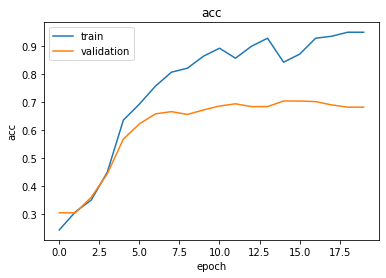

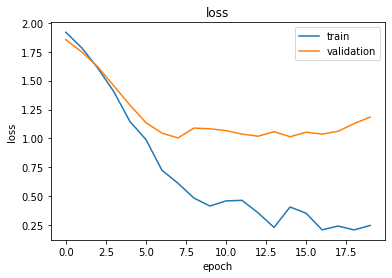

In [32]:
plot_history(history)

Evaluate the best model on the test set.

Note that `Cluster-GCN` performance can be very poor if using random graph clustering. Using METIS for graph clustering produces considerably better results.

In [33]:
test_gen = generator.flow(test_data.index, test_targets)

In [34]:
test_metrics = model.evaluate_generator(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Test Set Metrics:
	loss: 1.2815
	acc: 0.6678


### Making predictions with the model

For predictions to work correctly, we need to remove the extra batch dimensions necessary for the implementation of `Cluster-GCN` to work. We can easily achieve this by adding a layer after the dense predictions layer to remove this extra dimension.

In [35]:
predictions_flat = layers.Lambda(lambda x: K.squeeze(x,0))(predictions)

In [36]:
predictions, predictions_flat

(<tf.Tensor 'dense/truediv:0' shape=(?, ?, 7) dtype=float32>,
 <tf.Tensor 'lambda_1/Squeeze:0' shape=(?, 7) dtype=float32>)

Now let's get the predictions for all nodes.

We need to create a new model using the same as before input Tensor and our new **predictions_flat** Tensor as the output. We are going to re-use the trained model weights.

In [37]:
model_predict = Model(inputs=x_inp, outputs=predictions_flat)

In [38]:
all_nodes = list(node_data.index)
all_gen = generator.flow(all_nodes, name="all_gen")
all_predictions = model_predict.predict_generator(all_gen)

In [39]:
all_predictions.shape

(2708, 7)

These predictions will be the output of the softmax layer, so to get final categories we'll use the `inverse_transform` method of our target attribute specifcation to turn these values back to the original categories.

In [40]:
node_predictions = target_encoding.inverse_transform(all_predictions)

Let's have a look at a few predictions after training the model:

In [41]:
len(all_gen.node_order)

2708

In [42]:
results = pd.DataFrame(node_predictions, 
                       index=all_gen.node_order).idxmax(axis=1)
df = pd.DataFrame({"Predicted": results, 
                   "True": node_data[node_label]},)
df.head(10)

,Predicted,True
1000012,subject=Rule_Learning,Rule_Learning
100197,subject=Neural_Networks,Neural_Networks
100701,subject=Case_Based,Case_Based
100935,subject=Neural_Networks,Genetic_Algorithms
100961,subject=Neural_Networks,Neural_Networks
101143,subject=Neural_Networks,Case_Based
101145,subject=Neural_Networks,Case_Based
101261,subject=Theory,Theory
101263,subject=Theory,Theory
101660,subject=Rule_Learning,Rule_Learning


## Node embeddings
Evaluate node embeddings as activations of the output of the last graph convolution layer in the GCN layer stack and visualise them, coloring nodes by their true subject label. We expect to see nice clusters of papers in the node embedding space, with papers of the same subject belonging to the same cluster.

To calculate the node embeddings rather than the class predictions, we create a new model with the same inputs as we used previously `x_inp` but now the output is the embeddings `x_out` rather than the predicted class. Additionally note that the weights trained previously are kept in the new model.

In [43]:
x_out_flat = layers.Lambda(lambda x: K.squeeze(x,0))(x_out)
embedding_model = Model(inputs=x_inp, outputs=x_out_flat)

In [44]:
emb = embedding_model.predict_generator(all_gen, verbose=1)
emb.shape

5/5 [==============================] - 0s 38ms/step


(2708, 32)

Project the embeddings to 2d using either TSNE or PCA transform, and visualise, coloring nodes by their true subject label

In [45]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np

Note that the embeddings from the GCN model have a batch dimension of 1 so we `squeeze` this to get a matrix of $N_{nodes} \times N_{emb}$.

In [46]:
X = emb
y = np.argmax(target_encoding.transform(node_data[[node_label]].reindex(index=all_gen.node_order).to_dict('records')), axis=1)

In [47]:
if X.shape[1] > 2:
    transform = TSNE  # PCA 

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X),
                                   index=all_gen.node_order) 
    emb_transformed['label'] =  y  # y_ser
else:
    emb_transformed = pd.DataFrame(X, index=list(G.nodes()))
    emb_transformed = emb_transformed.rename(columns = {'0':0, '1':1})
    emb_transformed['label'] = y

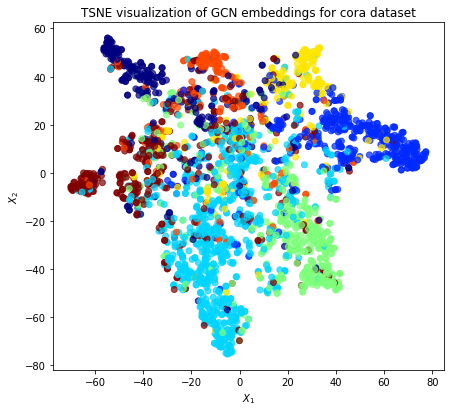

In [48]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(emb_transformed[0], 
           emb_transformed[1], 
           c=emb_transformed['label'].astype("category"), 
           cmap="jet", 
           alpha=alpha)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title('{} visualization of GCN embeddings for cora dataset'.format(transform.__name__))
plt.show()